# Topic extraction

In [1]:
%load_ext autotime

import numpy
import sklearn

n_components = 20
n_top_words = 50

In [2]:
# Load dataset
import pickle
dataset = pickle.load(open('dataset.pkl', 'rb'))

time: 1.02 s


In [3]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

    
def topic_counts(model, transformed):
    filtered = transformed[numpy.sum(transformed, axis=1) > 0]
#     print('%d/%d samples classified' % (len(filtered), len(transformed)))
    
    row_sums = filtered.sum(axis=1)
    normalised = filtered / row_sums[:, numpy.newaxis]
    return normalised.sum(axis=0)
    
def print_topics(model, transformed, feature_names, n_top_words):
    counts = topic_counts(model, transformed)
    
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d (%d samples)" % (topic_idx, counts[topic_idx]))
        terms = ", ".join([
            feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]
        ])
        print('  ', terms)
    print()



time: 1.97 ms


In [4]:
%config InlineBackend.figure_format = 'retina'

import wordcloud
import matplotlib.pyplot as plt

def make_wordcloud(topic, features, n_words=50, w=800, h=600):
    words =       [features[i] for i in topic.argsort()[:-n_words - 1:-1]]
    frequencies = [topic[i]    for i in topic.argsort()[:-n_words - 1:-1]]

    data = dict(zip(words, frequencies))

    return wordcloud.WordCloud(
        width = w, height = h, 
        background_color ='white',
        prefer_horizontal = 1,
        relative_scaling = 0.2,
        min_font_size = h/40
    ).generate_from_frequencies(data) 


def render_clouds(model, features, results):
    counts = topic_counts(model, results)

    fig=plt.figure(figsize=(16, 12))
    columns = 5
    rows = 4
    for i in range(0, columns*rows):
        img = make_wordcloud(model.components_[i], features)
        subp = fig.add_subplot(rows, columns, i+1)
        subp.set_title("Topic #%d (%d%% posts)" % (i, 100 * counts[i] / counts.sum()))
        plt.imshow(img)
        plt.axis("off")
        plt.tight_layout(pad = 5.0)
    plt.show()

time: 156 ms


In [5]:
print("Vectorizing documents...")

import sklearn.feature_extraction.text
vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    vocabulary=dataset['vocabulary'],
    analyzer=lambda x: x
)
print('Vobabulary size: %d' % len(dataset['vocabulary']))

documents_vector = vectorizer.fit_transform(dataset['documents'])
documents_vector.shape

Vectorizing documents...
Vobabulary size: 3221


(182080, 3221)

time: 2.02 s


In [6]:
print("Fitting LDA model features")

import sklearn.decomposition
with sklearn.utils.parallel_backend('loky', n_jobs=24):
    lda = sklearn.decomposition.LatentDirichletAllocation(n_components=n_components,
                                    max_iter=10,
                                    batch_size=2048, # default 128
                                    evaluate_every=2, # default 0
                                    n_jobs=16,
                                    learning_method='online',
                                    doc_topic_prior=(1./n_components), # alpha, default 1/N
#                                     doc_topic_prior=(1e-2 * n_components),
                                    topic_word_prior=(1./n_components), # eta, default 1/N
#                                     topic_word_prior=(1e-2 * n_features),
#                                     learning_decay=0.7,
#                                     learning_offset=10.,
                                    random_state=0,
                                    verbose=1)
    lda_results = lda.fit_transform(documents_vector)

Fitting LDA model features
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10, perplexity: 967.0141
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10, perplexity: 957.3793
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10, perplexity: 954.6087
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10, perplexity: 953.4035
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10, perplexity: 952.7910
time: 2min 32s


100%|██████████| 182080/182080 [00:00<00:00, 189870.13it/s]


{0: 6290, 1: 18079, 2: 5068, 3: 4783, 4: 10277, 5: 7258, 6: 22138, 7: 5162, 8: 4718, 9: 9427, 10: 5364, 11: 14217, 12: 5584, 13: 4140, 14: 5028, 15: 6345, 16: 17992, 17: 6866, 18: 13003, 19: 10341}


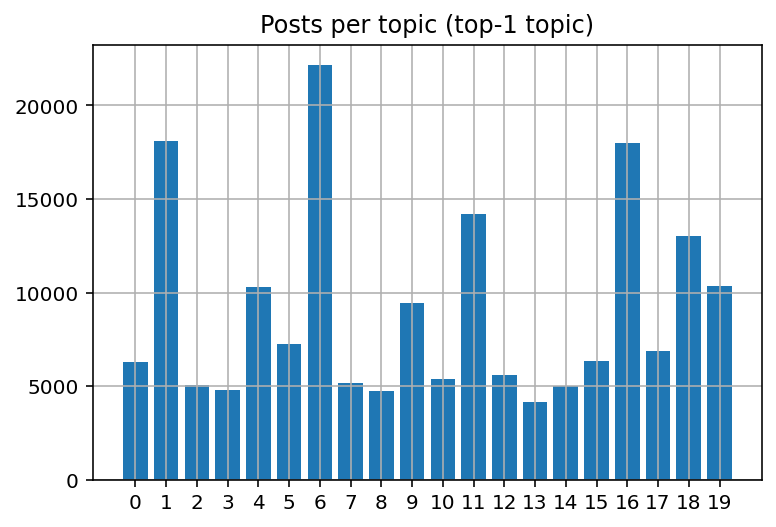

time: 1.13 s


In [7]:
from tqdm import tqdm

counts = {}
for k in range(lda_results.shape[1]):
    counts[k] = 0
for res in tqdm(lda_results):
    for k in numpy.argsort(res)[-1:]:
        counts[k] += 1

print(counts)

import matplotlib.pyplot as plt

fig, sub = plt.subplots()
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()))
plt.grid()
sub.set_title('Posts per topic (top-1 topic)')
plt.show()

100%|██████████| 182080/182080 [00:01<00:00, 140284.04it/s]


{0: 27425, 1: 36134, 2: 21300, 3: 21150, 4: 33281, 5: 20894, 6: 40849, 7: 16661, 8: 19829, 9: 21664, 10: 28858, 11: 34096, 12: 29978, 13: 17420, 14: 24176, 15: 21685, 16: 43909, 17: 23789, 18: 27687, 19: 35455}


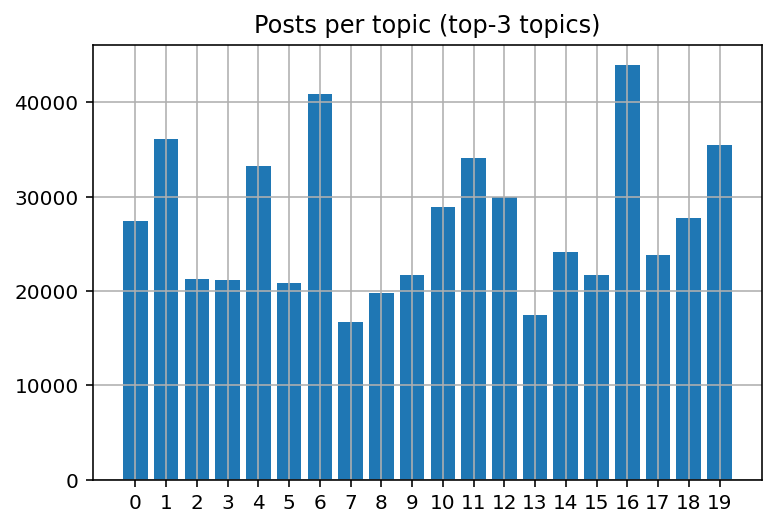

time: 1.46 s


In [8]:
from tqdm import tqdm

counts = {}
for k in range(lda_results.shape[1]):
    counts[k] = 0
for res in tqdm(lda_results):
    for k in numpy.argsort(res)[-3:]:
        counts[k] += 1

print(counts)

import matplotlib.pyplot as plt

fig, sub = plt.subplots()
plt.bar(counts.keys(), counts.values())
plt.xticks(list(counts.keys()))
plt.grid()
sub.set_title('Posts per topic (top-3 topics)')
plt.show()

Topics in LDA model:


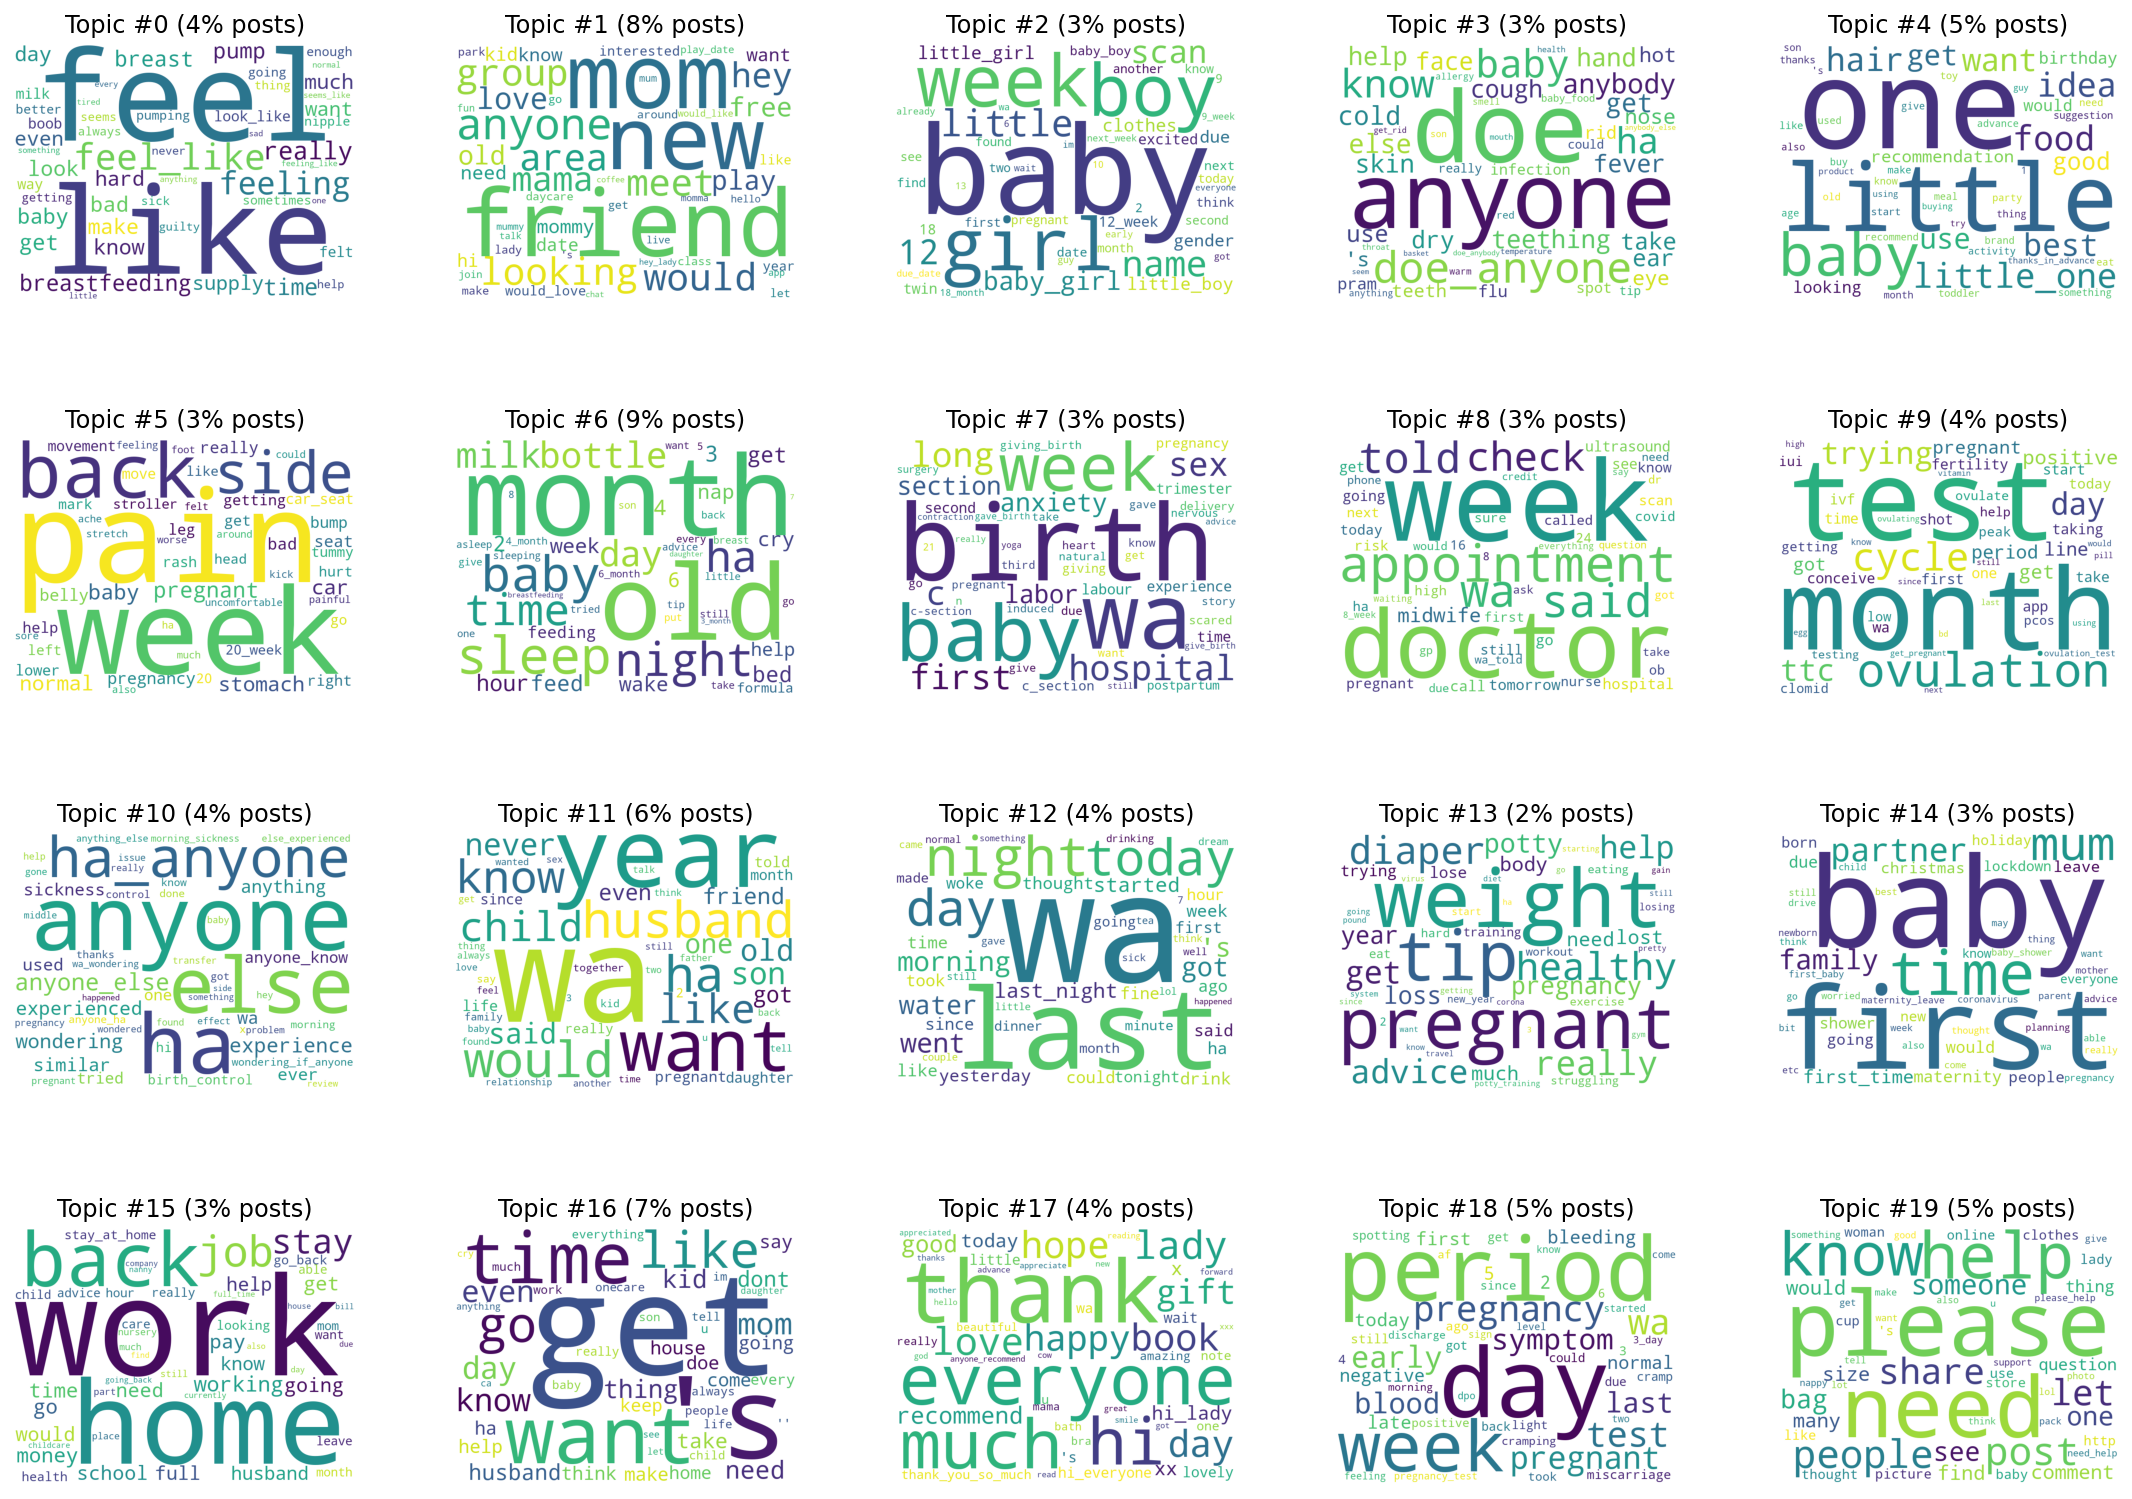

time: 9.87 s


In [9]:
print("Topics in LDA model:")
feature_names = vectorizer.get_feature_names()
render_clouds(lda, feature_names, lda_results)